<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Displaying images using the LSST astronomical framework (afw) library</b> <br>
Last verified to run on 2021-08-16 with LSST Science Pipelines release w_2021_33 <br>
Contact authors: Alex Drlica-Wagner, Jeff Carlin <br>
Target audience: All DP0 delegates. <br>
Container Size: medium <br>
Questions welcome at <a href="https://community.lsst.org/c/support/dp0">community.lsst.org/c/support/dp0</a> <br>
Find DP0 documentation and resources at <a href="https://dp0-1.lsst.io">dp0-1.lsst.io</a> <br>

**Credit:** This tutorial is based on the [`AFW_Display_Demo.ipynb`](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Visualization/AFW_Display_Demo.ipynb) notebook originally written by Brant Robertson and maintained by the LSST Stack Club. Please consider acknowledging Brant Robertson, Alex Drlica-Wagner, and Jeff Carlin in any publications or software releases that make use of this notebook's contents.

More examples of the use of `lsst.afw.display` can be found in the [LSST Science Pipelines documentation](https://pipelines.lsst.io/getting-started/display.html). 

### Learning Objectives

This tutorial is designed to help users get a brief feel for the `lsst.afw.display` library that enables the visual inspection of data. The [`lsst.afw` library](https://github.com/lsst/afw) provides an "Astronomical Framework" (afw) while the `lsst.daf.*` libraries (see, e.g., [daf_base](https://github.com/lsst/daf_base)) provides a Data Access Framework (daf). Both libraries are used in this tutorial, with the `lsst.daf.butler` library used to access a calibrated exposure (calexp) and the `lsst.afw.display` library used to show the exposure image on the screen.

### Set Up

In [1]:
# What version of the Stack are we using?
! echo $IMAGE_DESCRIPTION
! eups list -s | grep lsst_distrib

Weekly 2021_33
lsst_distrib          22.0.1-3-g7ae64ea+3baa4596b0 	current w_2021_33 setup


### 1. Import Common Python Libraries

The [`matplotlib`](https://matplotlib.org/), [`numpy`](http://www.numpy.org/), and [`astropy`](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, and astronomical data analysis. We will use these packages below, including the `matplotlib.pyplot` plotting sublibrary and the [`astropy.wcs`](https://docs.astropy.org/en/stable/wcs/index.html) package for dealing with World Coordinate Systems (WCS). We also import the [`warnings` library](https://docs.python.org/2/library/warnings.html) to prevent some routine warning messages from printing to the screen.

In [2]:
# allow for matplotlib to create inline plots in our notebook
%matplotlib inline
import matplotlib.pyplot as plt      # imports matplotlib.pyplot as plt
import warnings                      # imports the warnings library
import gc                            # imports python's garbage collector
from astropy.wcs import WCS          # imports astropy's World Coordinate System function WCS

And let the kernel know that we're happy not to have some useful warnings printed during this tutorial.

In [3]:
# prevent some helpful but ancillary warning messages from printing
#   during some LSST DM Release calls
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

Matplotlib stores the data array associated with an image that is plotted. Since the LSST images are large (~4k x 4k pixels), this can eventually lead to a memory overflow, which will cause the notebook kernel to die. To mitigate this issue, we define a function to clean up after we plot them.

In [4]:
def remove_figure(fig):
    """Remove a figure to reduce memory footprint. """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()      # clear the figure
    plt.close(fig) # close the figure
    gc.collect()   # call the garbage collector

As a last preparatory task, we set the parameters of `matplotlib.pyplot` to give us a large default size for an image, and set some other plotting parameters to make things look nice.

In [5]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

### 2. Load the LSST Science Pipelines

First, we load the `lsst.afw.display` library to gain access to the image visualization routines we'd like to use, and the `lsst.daf.butler` library, which is used to access data products.

In [6]:
# load lsst.afw.display to gain access to image visualization routines.
import lsst.afw.display as afwDisplay
# load the Butler, which provides programmatic access to LSST data products.
from lsst.daf.butler import Butler

### 3. Load the Data to Visualize

To display an image, we must first load some data. These data have been processed with the LSST Science Pipelines, and are organized in a structure that enables us to access them through the `Butler`. For more information on the `Butler`, see [lsst.daf.butler](https://pipelines.lsst.io/modules/lsst.daf.butler/index.html).

The DP0.1 data set contains simulated images from the LSST DESC Data Challenge 2 (DC2). These data are available in an S3 bucket `s3://butler-us-central1-dp01`. We access a single image from a specific visit (`192350`) and detector (`175`).

Once we define a string that contains the data directory, we start the `Butler` instance using the `lsst.daf.butler` library and its `Butler` class. The `Butler` object is initialized with a string containing the data directory we wish to access. Running the cell may take a few moments.

With the `Butler` instance now generated using our data directory, we can retrieve the desired calibrated exposure by telling the butler which filter ("band"), CCD ("detector", and visit we wish to view. To do this, we define a dictionary with the required information.

In [7]:
dataId = {'visit': 192350, 'detector': 175, 'band': 'i'}
# Note: because the combination of visit+detector already uniquely identifies
# the exposure, specifying "band" above is unnecessary.

repo = 's3://butler-us-central1-dp01'
collection = '2.2i/runs/DP0.1'
butler = Butler(repo, collections=collection)

# Retrieve the data using the `butler` instance and its function `get()`
calexp = butler.get('calexp', **dataId)

### 4.1: Use AFWDisplay to Visualize the Image

Now, with a `Butler` instance defined and a calibrated exposure retrieved, we can use [`lsst.afw.display`](https://github.com/lsst/afw/tree/master/python/lsst/afw/display) to visualize the data.  The next task is to let AFWDisplay know that we want it to use `matplotlib` as our default display backend. To do this, we use the `setDefaultBackend()` function. Remember that we made an alias to `lsst.afw.display` called `afwDisplay`, so we'll use that to call `setDefaultBackend()`.

In [8]:
# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

We are now set to display the image. To do this, we:

1. First create a `matplotlib.pyplot` figure using `plt.figure()` -- this will be familiar to anyone with experience using `matplotlib`.
2. Then create an alias to the `lsst.afw.display.Display` method that will allow us to display the data to the screen.  This alias will be called `display`.
3. Before showing the data on the screen, we have to decide how to apply an image stretch given the data. The algorithm we'll use is `asinh` -- familiar from SDSS images -- with a range of values set by `zscale`. To do this, we use the `scale()` function provided by `lsst.afw.display`. See the `scale()` function definition in the [`interface.py` file of the lsst.afw.display library](https://github.com/lsst/afw/blob/master/python/lsst/afw/display/interface.py).
4. Finally, we can display the image. To do this, we provide the `mtv()` method the `image` member of our calibrated image retrieved by the `butler`. We can then use `plt.show()` to display our figure.

All these tasks are best done within the same notebook cell.

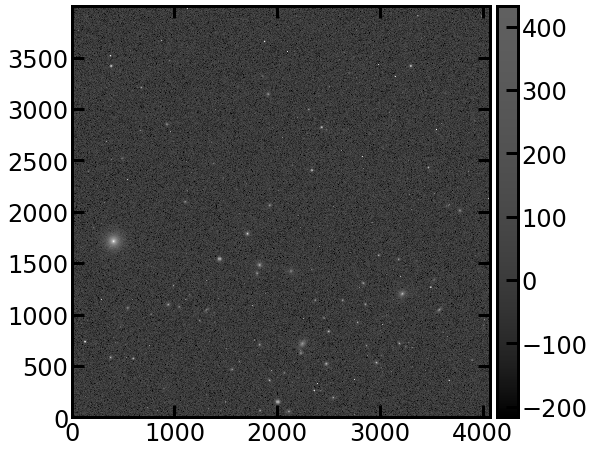

In [9]:
# create a matplotlib.pyplot figure
fig, ax = plt.subplots()
# get an alias to the lsst.afw.display.Display() method
display = afwDisplay.Display(frame=fig)
# set the image stretch algorithm and range
display.scale('asinh', 'zscale')
# load the image into the display
display.mtv(calexp.image)
# show the corresponding pyplot figure
plt.show()
# clean up memory
remove_figure(fig)

To see the image axes in sky coordinates instead of pixel coordinates, a simple option is to use astropy's World Coordinate System (WCS) package, along with matplotlib.pyplot's ``subplot``, ``imshow``, and ``grid`` functions. 
Recall that we imported ``matplotlib.pyplot`` as ``plt`` already, and that we imported the ``astropy.wcs.WCS`` function as simply ``WCS``.
Find more information about [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) (``cmap``).

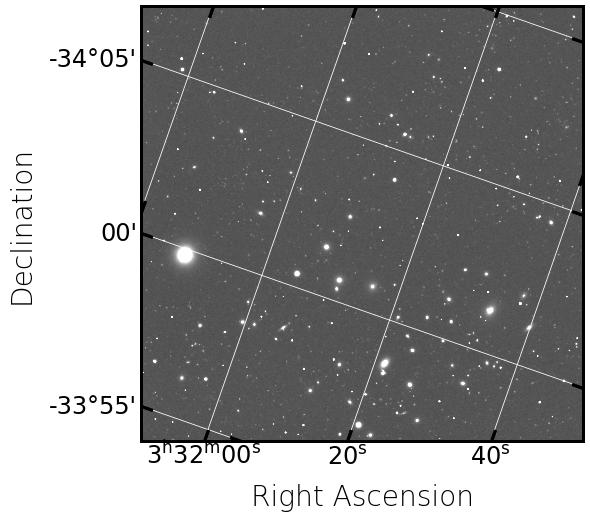

In [10]:
fig = plt.figure()
# Set the figure's projection to be the WCS of the calexp
plt.subplot(projection=WCS(calexp.getWcs().getFitsMetadata()))
# Display the calexp image data array using the gray colormap (cmap)
#  and use approximately the same min and max scale values as above
im = plt.imshow(calexp.image.array, cmap='gray', vmin=-200.0, vmax=400, origin='lower')
# Add solid white grid lines
plt.grid(color='white', ls='solid')
# Label axes
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()
# Clean up memory
remove_figure(fig)

Often you may want to plot two images side-by-side. This can be done by creating matplotlib subplots.

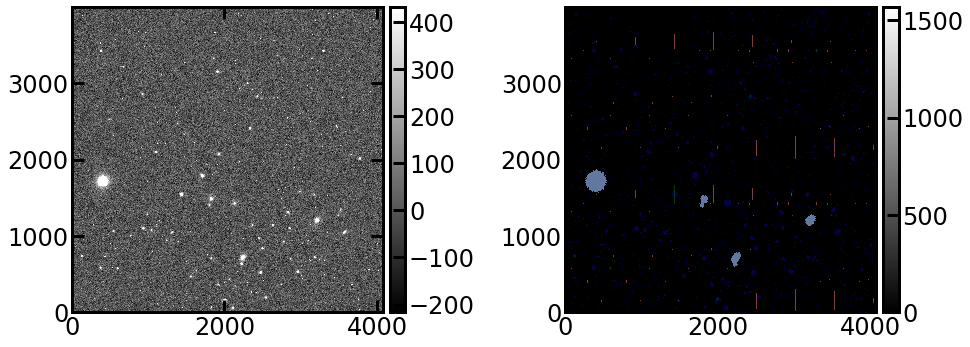

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
plt.sca(ax[0])  # set the first axis as current
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(calexp.image)
plt.sca(ax[1])  # set the second axis as current
display2 = afwDisplay.Display(frame=fig)
display2.mtv(calexp.mask)
plt.tight_layout()
plt.show()
remove_figure(fig)

It is also possible to plot the mask on top of the image using the `calexp.maskedImage`.

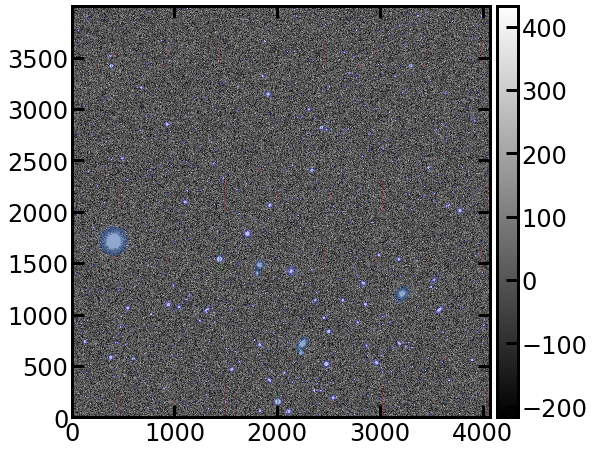

In [12]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('linear', 'zscale')
display.mtv(calexp.maskedImage)
plt.show()
remove_figure(fig)

**Congratulations!** We've plotted an image using `lsst.afw.display`!

### 4.2: Use AFWDisplay to Visualize the Image and Mask Plane

The `calexp` returned by the butler contains more than just the image pixel values (see the Stack Club [calexp tutorial](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/Calexp_guided_tour.ipynb) for more details). One other component is the mask plane associated with the image. `afwDisplay` provides a nice pre-packaged interface for overplotting the mask associated with an image. A mask is composed of a set of "mask planes," 2D binary bit maps corresponding to pixels that are masked for various reasons (see [here](https://pipelines.lsst.io/v/DM-11392/getting-started/display.html#interpreting-displayed-mask-colors) for more details).

We'll follow the same steps as above to display the image, but we'll add a few modifications

1. We explicitly set the transparency of the overplotted mask (0 = transparent, 1 = opaque)
2. We explicitly set the color of the 'DETECTED' mask plane to 'blue' (i.e., all pixels associated with detected objects).
3. We pass the full `calexp` object to `mtv` instead of just the image plane.

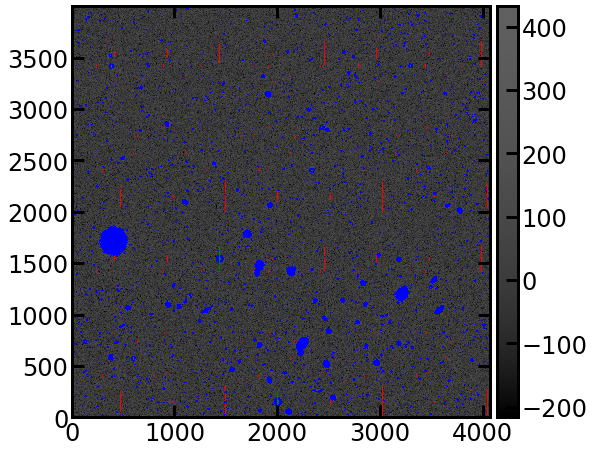

In [13]:
# create a matplotlib.pyplot figure
fig, ax = plt.subplots()
# get an alias to the lsst.afw.display.Display() method
afw_display = afwDisplay.Display(frame=fig)
# set the image stretch algorithm and range
afw_display.scale('asinh', 'zscale')
# set the transparency of the mask plane (1 = opaque)
afw_display.setMaskTransparency(0.4)
# set the color for a single plane in the mask
afw_display.setMaskPlaneColor('DETECTED', 'blue')
# load the image and mask plane into the display
afw_display.mtv(calexp)
# show the corresponding pyplot figure
plt.show()
# clean up memory
remove_figure(fig)

The `afw_display` object contains more information about the mask planes that can be accessed

In [14]:
# Print the colors associated to each plane in the mask
print("Mask plane bit definitions:\n", afw_display.getMaskPlaneColor())
print("\nMask plane methods:\n")
help(afw_display.setMaskPlaneColor)

Mask plane bit definitions:
 {'BAD': 'red', 'CR': 'magenta', 'EDGE': 'yellow', 'INTERPOLATED': 'green', 'SATURATED': 'green', 'DETECTED': 'blue', 'DETECTED_NEGATIVE': 'cyan', 'SUSPECT': 'yellow', 'NO_DATA': 'orange', 'INTRP': 'green', 'SAT': 'green'}

Mask plane methods:

Help on method setMaskPlaneColor in module lsst.afw.display.interface:

setMaskPlaneColor(name, color=None) method of lsst.afw.display.interface.Display instance
    Request that mask plane name be displayed as color
    
    Parameters
    ----------
    name : `str` or `dict`
        Name of mask plane or a dictionary of name -> colorName
    color : `str`
        The name of the color to use (must be `None` if ``name`` is a `dict`)
    
        Colors may be specified as any X11-compliant string (e.g. `"orchid"`), or by one
        of the following constants in `lsst.afw.display` : `BLACK`, `WHITE`, `RED`, `BLUE`,
        `GREEN`, `CYAN`, `MAGENTA`, `YELLOW`.
    
        If the color is "ignore" (or `IGNORE`) then

### 5. More Information about lsst.afw.display

To get some more information about `lsst.afw.display`, we can print the method list to see what's available. The next cell will print `lsst.afw.display` methods to the screen.

In [15]:
method_list = [fun for fun in dir(display) if callable(getattr(display, fun))]
print(method_list)

['Buffering', '_Buffering', '__class__', '__del__', '__delattr__', '__dir__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'close', 'delAllDisplays', 'dot', 'erase', 'flush', 'getActiveCallbackKeys', 'getDefaultBackend', 'getDefaultFrame', 'getDisplay', 'getMaskPlaneColor', 'getMaskTransparency', 'incrDefaultFrame', 'interact', 'line', 'maskColorGenerator', 'mtv', 'pan', 'scale', 'setCallback', 'setDefaultBackend', 'setDefaultFrame', 'setDefaultImageColormap', 'setDefaultMaskPlaneColor', 'setDefaultMaskTransparency', 'setImageColormap', 'setMaskPlaneColor', 'setMaskTransparency', 'show', 'zoom']


If you'd like to learn more about any given function, please see the [`lsst.afw.display` source code](https://github.com/lsst/afw/tree/master/python/lsst/afw/display).

You can also read the API documentation about the above functions using the Jupyter notebook `help()` function:

In [16]:
help(display.scale)

Help on method scale in module lsst.afw.display.interface:

scale(algorithm, min, max=None, unit=None, *args, **kwargs) method of lsst.afw.display.interface.Display instance
    Set the range of the scaling from DN in the image to the image display
    
    Parameters
    ----------
    algorithm : `str`
        Desired scaling (e.g. "linear" or "asinh")
    min
        Minimum value, or "minmax" or "zscale"
    max
        Maximum value (must be `None` for minmax|zscale)
    unit
        Units for min and max (e.g. Percent, Absolute, Sigma; `None` if min==minmax|zscale)
    *args
        Optional arguments to the backend
    **kwargs
        Optional keyword arguments to the backend



In [17]:
help(display.mtv)

Help on method mtv in module lsst.afw.display.interface:

mtv(data, title='', wcs=None) method of lsst.afw.display.interface.Display instance
    Display an `~lsst.afw.image.Image` or `~lsst.afw.image.Mask` on a display
    
    Notes
    -----
    Historical note: the name "mtv" comes from Jim Gunn's forth imageprocessing
    system, Mirella (named after Mirella Freni); The "m" stands for Mirella.



### 6. Extract a cutout image

Say we want to grab a cutout of the DP0.1 coadded images at a specific location. In order to do this, we need a few other packages from the LSST Science Pipelines. In particular, we'll need access to the geometry and coordinate packages.

In [18]:
import lsst.geom as geom

First we will define a convenience function to extract a cutout from a deep coadd image, if given an RA, Dec position and desired image size.

In [19]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              immediate=True, dataId=coaddId)

    return cutout_image

Before we extract a cutout image, let's take a look at what a full 4k x 4k pixel "patch" image looks like. Previously we were extracting a single visit image spanning only one detector. For the rest of this notebook, we will look at coadded images made up of multiple exposures that have been combined.

Let's grab a "deepCoadd_calexp" image and display the entire patch:

In [20]:
dataId = {'tract': 4431, 'patch': 17, 'band': 'i'}

# Retrieve the data using the `butler` instance and its function `get()`
coadd_calexp = butler.get('deepCoadd_calexp', **dataId)

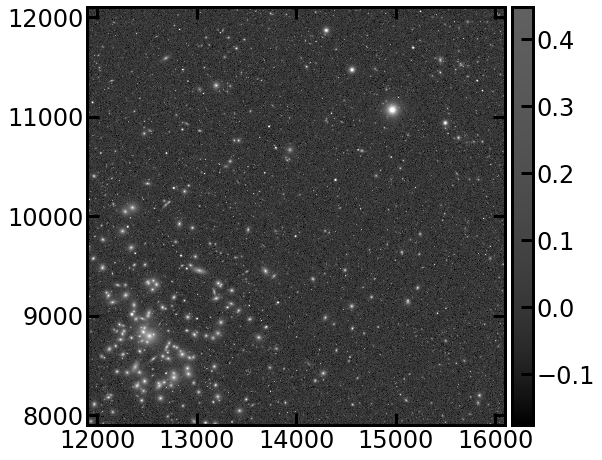

In [21]:
# create a matplotlib.pyplot figure
fig, ax = plt.subplots()
# get an alias to the lsst.afw.display.Display() method
display = afwDisplay.Display(frame=fig)
# set the image stretch algorithm and range
display.scale('asinh', 'zscale')
# load the image into the display
display.mtv(coadd_calexp.image)
plt.show()
# clean up memory
remove_figure(fig)

Wow - check out that rich galaxy cluster in the lower-left portion of the image! Let's use the function we defined above to get a cutout around the position of that cluster.

(You may have noticed, though, that the image above is displaying pixel numbers rather than RA, Dec coordinates. As a quick aside, we'll show you how to get the sky coordinates corresponding to an XY pixel position.)

In [22]:
# First, we need to extract the WCS solution, which provides the mapping
#   between XY pixel values and sky coordinates:
wcs = coadd_calexp.getWcs()

# Print the WCS info to see what it contains:
print(wcs)

FITS standard SkyWcs:
Sky Origin: (55.6521739130, -31.9834710744)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel


In [23]:
# The cluster seems to be centered at about (X, Y) = (12500, 8500).
# We can use the "pixelToSky" method of the WCS to get the sky coordinates:
radec = wcs.pixelToSky(12500, 8500)

print(radec.getRa().asDegrees(), radec.getDec().asDegrees())

55.75068348139294 -32.28892993702245


Now use this RA, Dec position to extract a cutout image that is centered on the galaxy cluster.

In [24]:
# Select a position at roughly the center of the galaxy cluster:
ra, dec = radec.getRa().asDegrees(), radec.getDec().asDegrees()
cutout_image = cutout_coadd(butler, ra, dec, datasetType='deepCoadd',
                            cutoutSideLength=501)
print("The size of the cutout in pixels is: ", cutout_image.image.array.shape)

The size of the cutout in pixels is:  (501, 501)


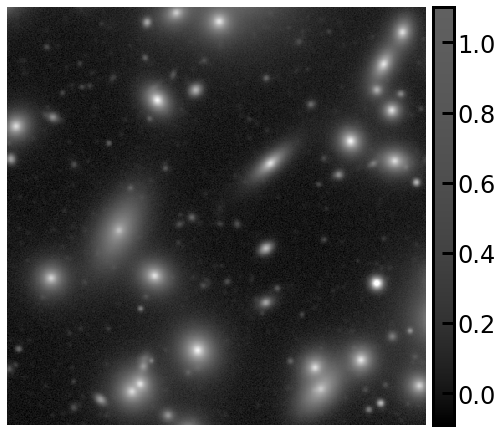

In [25]:
fig, ax = plt.subplots()
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(cutout_image.image)
ax.axis('off')
plt.show()
remove_figure(fig)

### 7. Plot an RGB composite image

That's a pretty cluster, but what if we really want to know about the colors of the stars and galaxies in that image? To do that, we can extract images taken with three different filters, then assign those images to the RGB channels of a color image.

First we'll load a tool from Astropy that helps create RGB images (see [this Astropy guide to creating RGB images](https://docs.astropy.org/en/stable/visualization/rgb.html?highlight=make_lupton_rgb) for more info), and make a convenience function to combine the steps of making an RGB image. (This function was originally written by Aaron Watkins and Nushkia Chamba for their [Stack Club Course](https://github.com/LSSTScienceCollaborations/StackClubCourse) project exploring surface photometry in the LSST Science Pipelines.)

In [26]:
from astropy.visualization import make_lupton_rgb

In [27]:
def createRGB(image, bgr="gri", stretch=1, Q=10, scale=None):
    """
    Create an RGB color composite image.

    Parameters
    ----------
    image : `MultibandExposure`
        `MultibandExposure` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e., keys of the exps dict)
        indicating what band to use for each channel. If `image` only has
        three filters then this parameter is ignored and the filters
        in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales the RGB channels.

    Returns
    -------
    rgb: ndarray
        RGB (integer, 8-bits per channel) colour image as an NxNx3 numpy array.
    """

    # If the image only has 3 bands, reverse the order of the bands
    #   to produce the RGB image
    if len(image) == 3:
        bgr = image.filters

    # Extract the primary image component of each Exposure with the
    #   .image property, and use .array to get a NumPy array view.

    if scale is None:
        r_im = image[bgr[2]].array  # numpy array for the r channel
        g_im = image[bgr[1]].array  # numpy array for the g channel
        b_im = image[bgr[0]].array  # numpy array for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]].array * scale[0]
        g_im = image[bgr[1]].array * scale[1]
        b_im = image[bgr[0]].array * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

We will use the `MultiBandExposure` object type from the LSST Science Pipelines `afw.image` package. One could also create a similar function that simply accepts three separate images without combining them into a MultiBand object.

In [28]:
from lsst.afw.image import MultibandExposure

In [ ]:
cutout_image_g = cutout_coadd(butler, ra, dec, band='g',
                              datasetType='deepCoadd', cutoutSideLength=701)
cutout_image_r = cutout_coadd(butler, ra, dec, band='r',
                              datasetType='deepCoadd', cutoutSideLength=701)
cutout_image_i = cutout_coadd(butler, ra, dec, band='i',
                              datasetType='deepCoadd', cutoutSideLength=701)

# Multiband exposures need a list of images and filters
coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
coadds = MultibandExposure.fromExposures(['g', 'r', 'i'], coadds)

Now we are ready to create the RGB (where, in case you're unfamiliar, the RGB denotes "red," "green," and "blue" channels) image. We will assign the g, r, and i-bands to the B, G, and R channels (i.e., g-band, as the bluest filter, will be in the blue channel, r-band in the green channel, and i-band as red). 

Finally, we will plot two versions of the image to demonstrate how you can change the relative scaling of each RGB channel to produce an image better highlights certain features. You can experiment with the "scale = []" keyword, or including different bands besides _gri_.

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20), nrows=1, ncols=2)

# original make_lupton_rgb without any scaling
rgb_original = createRGB(coadds.image, bgr=['g', 'r', 'i'], scale=None)
ax[0].imshow(rgb_original, origin='lower')
ax[0].set_title('original', fontsize=30)

# make_lupton_rgb with scaled rgb channels
ax[1].set_title('re-scaled', fontsize=30)
rgb_scaled = createRGB(coadds.image, bgr=['g', 'r', 'i'],
                       scale=[0.6, 0.7, 1.0])
ax[1].imshow(rgb_scaled, origin='lower')

ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()

# clean up memory
remove_figure(fig)

Congratulations - you have now learned how to display images, create cutouts centered on a given position, and make multi-band color images. Enjoy exploring the DP0 images!

### Additional Documentation

If you'd like some more information on `lsst.afw.display`, please have a look at the following websites:

* [Info on image indexing conventions.](https://pipelines.lsst.io/modules/lsst.afw.image/indexing-conventions.html)  
* [afw.display Doxygen website](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/namespacelsst_1_1afw_1_1display.html)  
* [afw.display GitHub website](https://github.com/RobertLuptonTheGood/afw/tree/master/python/lsst/afw/display)  
* [Getting Started on Image Display (pipelines.lsst.io)](https://pipelines.lsst.io/getting-started/display.html)